# 🧠 The Monty Hall Problem

The Monty Hall problem is a classic puzzle in probability theory that challenges
our intuition about conditional probability.

You are on a game show with **three doors**:

- Behind one door is a **car**
- Behind the other two are **goats**

### The rules
1. You choose one door.
2. The host, who knows where the car is, opens **one of the remaining doors**,
   always revealing a goat.
3. You are given the option to **stay** with your original choice or **switch**
   to the remaining unopened door.

The question is simple:

> **Should you switch?**

### 🤔 Naive Intuition

After the host opens a door, two doors remain.
It feels natural to assume that the probability of winning is now 50–50.

This intuition is compelling — and wrong.

To understand why, we will:
1. Formalize the rules of the game
2. Simulate the process step by step
3. Compare strategies using computation

## The Mathematical Proof (Bayes' Theorem)

Intuition suggests the odds are 50/50 because two doors remain. However, the host's action adds **information** to the system. Let's prove why switching works using Bayes' Theorem.

Let:
* $C_i$: The Car is behind Door $i$ (for $i \in \{1, 2, 3\}$).
* $X_1$: The Player picks Door 1.
* $H_3$: The Host opens Door 3.

We want to find the probability that the car is behind Door 2 given the host opened Door 3: **$P(C_2 | H_3, X_1)$**.
 
Using Bayes' Theorem:
$$ P(C_2 | H_3, X_1) = \frac{P(H_3 | C_2, X_1) \cdot P(C_2)}{P(H_3 | X_1)} $$

**Step 1: The Priors**
The car is equally likely to be behind any door.
$$ P(C_1) = P(C_2) = P(C_3) = \frac{1}{3} $$

**Step 2: The Likelihoods (The Host's Constraints)**
* If the car is behind Door 2 ($C_2$), and we picked Door 1, the host **must** open Door 3 (he can't open Door 1, and he can't reveal the car at Door 2).
$$ P(H_3 | C_2, X_1) = 1 $$
* If the car is behind Door 1 ($C_1$), the host can open either Door 2 or Door 3 randomly.
$$ P(H_3 | C_1, X_1) = \frac{1}{2} $$

**Step 3: The Total Probability (Denominator)**
$$ P(H_3 | X_1) = P(H_3 | C_1)P(C_1) + P(H_3 | C_2)P(C_2) + P(H_3 | C_3)P(C_3) $$
$$ P(H_3 | X_1) = (\frac{1}{2} \cdot \frac{1}{3}) + (1 \cdot \frac{1}{3}) + (0 \cdot \frac{1}{3}) = \frac{1}{6} + \frac{1}{3} = \frac{1}{2} $$

**Step 4: The Result**
$$ P(C_2 | H_3, X_1) = \frac{1 \cdot (1/3)}{1/2} = \frac{2}{3} $$

**Conclusion:** The probability of winning if you switch to Door 2 is **2/3**, while staying at Door 1 is only **1/3**.


## The Computational Experiment
We will now build a Python class to simulate this game several (about 10,000) times to verify our math.

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class MontyHall:
    """
    A simulator for the Monty Hall problem.
    
    The 'game' consists of 3 doors:
    [0] [1] [2]
    
    One hides a prize (Car), two hide duds (Goats).
    """
    
    def __init__(self, num_doors=3):
        """
        Initialize the game settings.
        
        Args:
            num_doors (int): Standard game uses 3, but logic holds for N > 3.
        """
        if num_doors < 3:
            raise ValueError("Standard Monty Hall requires at least 3 doors.")
        self.num_doors = num_doors

    def run_single_episode(self, switch: bool) -> bool:
        """
        Simulates a single round of the game.

        Logic Flow:
        1. Place Car:       [G] [C] [G]  (Random hidden state)
        2. Player Picks:    ^ Pick 0
        3. Host Opens:              ^ Opens 2 (Must be G, not Player's pick)
        4. Switch/Stay:         ^ Result depends on strategy
        
        Args:
            switch (bool): 
                True  -> Player switches to the remaining closed door.
                False -> Player stays with their original choice.
                           
        Returns:
            bool: True if final choice is the Car.
        """
        # --- PHASE 1: SETUP ---
        doors = list(range(self.num_doors))
        car_position = random.choice(doors)
        player_choice = random.choice(doors)
        
        # --- PHASE 2: THE REVEAL ---
        # The host must open a door that is:
        # 1. NOT the car (cannot ruin the game)
        # 2. NOT the player's choice (cannot force a loss immediately)
        available_for_host = [
            d for d in doors 
            if d != car_position and d != player_choice
        ]
        host_opens = random.choice(available_for_host)
        
        # --- PHASE 3: THE DECISION ---
        if switch:
            # Player switches to the only other door left closed.
            # In a 3-door game: Total(3) - Player(1) - Host(1) = 1 door left.
            remaining_doors = [
                d for d in doors 
                if d != player_choice and d != host_opens
            ]
            final_choice = remaining_doors[0]
        else:
            final_choice = player_choice
            
        return final_choice == car_position

    def run_simulation(self, trials=1000):
        """
        Runs the simulation 'trials' times for BOTH strategies independenty.
        
        Returns:
            dict: {'stay_wins': int, 'switch_wins': int}
        """
        results = {'stay_wins': 0, 'switch_wins': 0}
        
        # Run batch for 'Stay' Strategy
        for _ in range(trials):
            if self.run_single_episode(switch=False):
                results['stay_wins'] += 1
                
        # Run batch for 'Switch' Strategy
        for _ in range(trials):
            if self.run_single_episode(switch=True):
                results['switch_wins'] += 1
                
        return results
        
    def plot_results(self, results, trials):
        """
        Generates a clean bar chart comparison of the strategies.
        """
        strategies = ['Stay', 'Switch']
        counts = [results['stay_wins'], results['switch_wins']]
        probs = [c / trials for c in counts]
        
        plt.figure(figsize=(10, 6))
        
        # Plot Bars
        bars = plt.bar(strategies, probs, color=['#e74c3c', '#2ecc71'], 
                      alpha=0.9, edgecolor='#2c3e50', linewidth=1.5)
        
        # Theoretical Reference Lines
        plt.axhline(y=1/3, color='#c0392b', linestyle='--', linewidth=2, label='Theory (Stay): 33.3%')
        plt.axhline(y=2/3, color='#27ae60', linestyle='--', linewidth=2, label='Theory (Switch): 66.7%')
        
        # Styling
        plt.ylim(0, 1)
        plt.ylabel('Win Probability', fontsize=12)
        plt.title(f'Simulation Results (N={trials:,} games)', fontsize=14, fontweight='bold')
        plt.legend(loc='upper left', frameon=True)
        plt.grid(axis='y', linestyle=':', alpha=0.6)
        
        # Annotate bars with percentages
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                     f'{height:.1%}',
                     ha='center', va='bottom', fontsize=12, fontweight='bold', color='#2c3e50')
        
        plt.show()

In [3]:
# %% Execution Script

# 1. Configuration
NUM_TRIALS = 10_000
print(f"Running Monte Carlo Simulation with {NUM_TRIALS:,} trials...")

# 2. Initialization
game = MontyHall(num_doors=3)

# 3. Processing
results = game.run_simulation(trials=NUM_TRIALS)

# 4. Text Report
print("\n--- Final Results ---")
print(f"Stay Strategy Wins:   {results['stay_wins']} ({results['stay_wins']/NUM_TRIALS:.1%})")
print(f"Switch Strategy Wins: {results['switch_wins']} ({results['switch_wins']/NUM_TRIALS:.1%})")


Running Monte Carlo Simulation with 10,000 trials...

--- Final Results ---
Stay Strategy Wins:   3327 (33.3%)
Switch Strategy Wins: 6561 (65.6%)


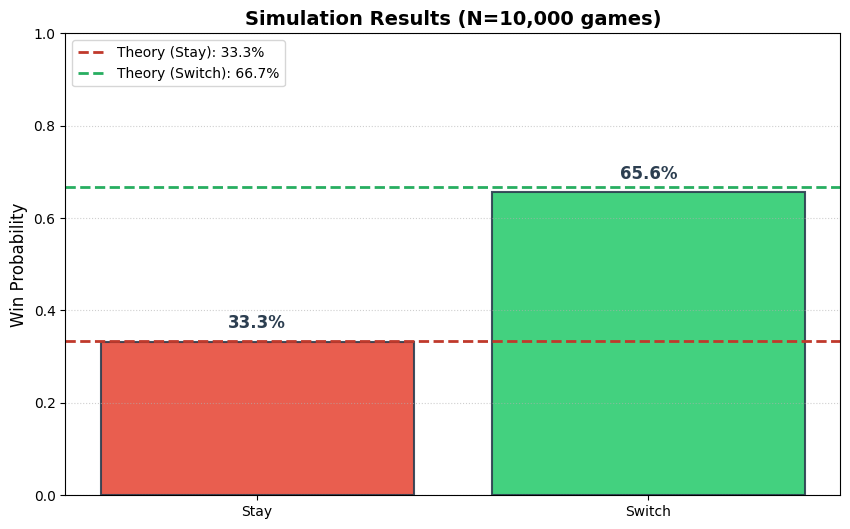

In [4]:
# %% Visualization
game.plot_results(results, NUM_TRIALS)

## Takeaway

* The Monty Hall problem is not paradoxical.
Our intuition fails because we ignore conditional information.
* By explicitly modeling the rules of the game, the correct behavior becomes unavoidable.